In [201]:
import librosa, numpy as np

from pathlib import Path

In [202]:
# GENERATION VARIABLES
song_path = 'shoobie.wav'
bpm = 101
kick_percentile_threshold = 3  # Percentile threshold for kick detection
video_switch_frequency = 2  # Switch video every N detected beats

# VIdEO VARIABLES
video_folder = Path("./video")
output_video = "output_no_audio.mp4"
output_final = "output_with_audio.mp4"

# Video settings
fps = 30
width, height = 1920, 1080
# Video effects
flash_effect = True
enable_lyrics = True
lyrics_text = """
I spend my life
doing anything you like
come on, and love me like you used to
"""

# Lyrics display settings
font_path = 'arial.ttf'  # Or path to custom font
font_size = 80
font_color = (255, 255, 255)  # White
outline_color = (0, 0, 0)  # Black
outline_thickness = 3

In [203]:

y, sr = librosa.load(song_path, sr=None)
S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

# Remove silence from the beginning
def detect_audio_start(y, sr, threshold=0.01, frame_length=2048, hop_length=512):
    """Detect where audio actually starts by finding first frame above threshold"""
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Find first frame where RMS exceeds threshold
    start_frame = 0
    for i, val in enumerate(rms):
        if val > threshold:
            start_frame = i
            break
    
    # Convert frame to sample
    start_sample = librosa.frames_to_samples(start_frame, hop_length=hop_length)
    
    # Save the offset for video processing
    audio_start_offset = start_sample / sr
    return [start_sample, audio_start_offset]

sample = detect_audio_start(y, sr)
start_sample = sample[0]
y = y[start_sample:]
S = S[:, start_sample // 512:]

print(f"Trimmed {start_sample / sr:.2f} seconds of silence from the beginning")

freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

def band_energy(S, freqs, f_low, f_high):
    mask = (freqs >= f_low) & (freqs < f_high)
    return S[mask].mean(axis=0)

low  = band_energy(S, freqs, 30, 120)
mid  = band_energy(S, freqs, 120, 2000)
high = band_energy(S, freqs, 2000, 12000)

# normalize & smooth
def smooth(x, alpha=0.05):
    y = np.zeros_like(x)
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

low, mid, high = map(smooth, [low, mid, high])

# identify “hits”
flux_low  = np.clip(np.diff(np.r_[low[0], low]), 0, None)
flux_mid  = np.clip(np.diff(np.r_[mid[0], mid]), 0, None)
flux_high = np.clip(np.diff(np.r_[high[0], high]), 0, None)

times = librosa.frames_to_time(np.arange(len(low)), sr=sr, hop_length=512)

Trimmed 0.00 seconds of silence from the beginning


In [204]:
print(f"Sample rate: {sr} Hz")
print(f"Duration: {len(y)/sr:.2f} seconds")
print(f"Number of frames: {len(low)}")

Sample rate: 48000 Hz
Duration: 12.21 seconds
Number of frames: 1145


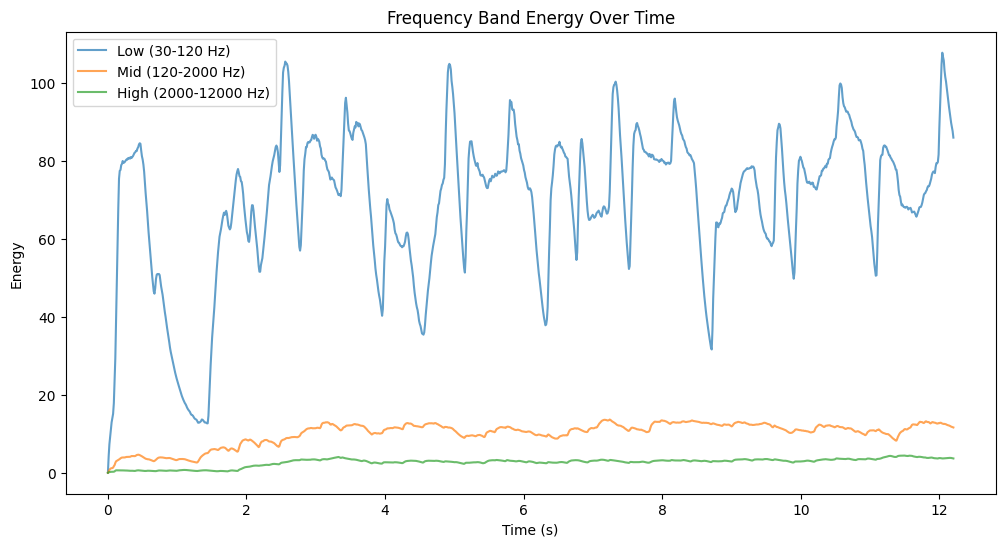

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(times, low, label='Low (30-120 Hz)', alpha=0.7)
plt.plot(times, mid, label='Mid (120-2000 Hz)', alpha=0.7)
plt.plot(times, high, label='High (2000-12000 Hz)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.legend()
plt.title('Frequency Band Energy Over Time')
plt.show()

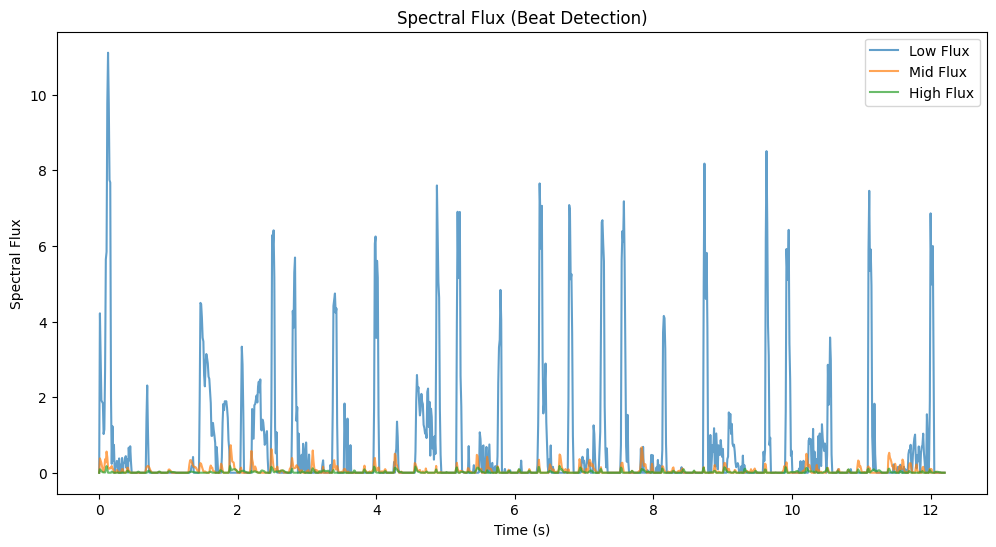

In [206]:
plt.figure(figsize=(12, 6))
plt.plot(times, flux_low, label='Low Flux', alpha=0.7)
plt.plot(times, flux_mid, label='Mid Flux', alpha=0.7)
plt.plot(times, flux_high, label='High Flux', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Spectral Flux')
plt.legend()
plt.title('Spectral Flux (Beat Detection)')
plt.show()

In [207]:
from scipy.signal import find_peaks

# Detect kicks using peak detection on low-frequency flux
# You can adjust height and distance parameters based on your audio
peak_indices, properties = find_peaks(
    flux_low, 
    height=np.percentile(flux_low, kick_percentile_threshold),
    distance=int(sr / 512 * (60 / bpm / video_switch_frequency))  # Minimum 1/16th note spacing based on BPM
)

# Create binary array (1 = kick detected, 0 = no kick)
kick_binary = np.zeros(len(flux_low))
kick_binary[peak_indices] = 1

# Get timestamps for kicks
kick_times = times[peak_indices]

print(f"Detected {len(kick_times)} kicks/808 hits")

Detected 29 kicks/808 hits


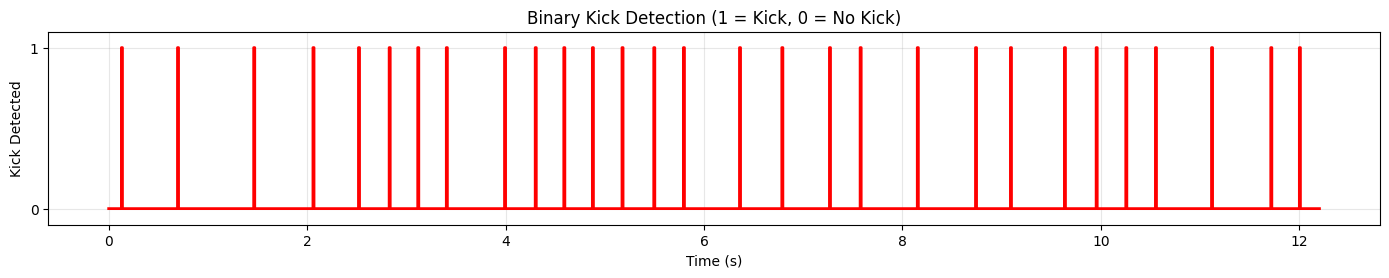

In [208]:
# Visualize combined binary events
plt.figure(figsize=(14, 10))

# Subplot 1: Kick detection only
plt.subplot(4, 1, 1)
plt.plot(times, kick_binary, drawstyle='steps-post', color='red', linewidth=2)
plt.ylim(-0.1, 1.1)
plt.xlabel('Time (s)')
plt.ylabel('Kick Detected')
plt.title('Binary Kick Detection (1 = Kick, 0 = No Kick)')
plt.yticks([0, 1])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [209]:
import soundfile as sf

# Generate separate click tracks
def create_click_track(binary_array, sr, hop_length=512, pitch=1000, duration=0.025, offset_seconds=0):
    # Include offset in total length
    total_length = len(y) + int(offset_seconds * sr)
    click_track = np.zeros(total_length)
    
    click_samples = int(sr * duration)
    click_sound = np.sin(2 * np.pi * pitch * np.linspace(0, duration, click_samples))
    click_sound *= np.hamming(click_samples)
    
    # Add offset to each click position
    offset_samples = int(offset_seconds * sr)
    
    for i, is_event in enumerate(binary_array):
        if is_event == 1:
            sample_idx = librosa.frames_to_samples(i, hop_length=hop_length)
            # Add the offset to sync with video
            sample_idx += offset_samples
            
            end_idx = min(sample_idx + click_samples, len(click_track))
            actual_click_length = end_idx - sample_idx
            click_track[sample_idx:end_idx] += click_sound[:actual_click_length]
    
    return click_track / np.max(np.abs(click_track)) if np.max(np.abs(click_track)) > 0 else click_track

# Create individual click tracks WITH offset
audio_offset = sample[1]  # Get the offset from earlier
kick_clicks = create_click_track(kick_binary, sr, offset_seconds=audio_offset)

# Save all versions
sf.write('clicks_kicks_only.wav', kick_clicks, sr)

# Create padded original audio to match click track length
y_padded = np.concatenate([np.zeros(int(audio_offset * sr)), y])

# Mix with padded original
mixed_kicks = y_padded * 0.7 + kick_clicks * 0.3
mixed_kicks = mixed_kicks / np.max(np.abs(mixed_kicks))

sf.write('music_with_metronome_and_kicks.wav', mixed_kicks, sr)

print("All click tracks saved with offset!")
print(f"Click track length: {len(kick_clicks) / sr:.2f}s")
print(f"Padded audio length: {len(y_padded) / sr:.2f}s")

All click tracks saved with offset!
Click track length: 12.21s
Padded audio length: 12.21s


In [211]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import random

audio_file = song_path

# Get video files
video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) 
    if f.lower().endswith(('.mp4', '.mov', '.avi', '.mkv'))]

print(f"Found {len(video_files)} video files")

# Get kick timestamps
kick_timestamps = times[kick_binary == 1]
print(f"Found {len(kick_timestamps)} kicks")

# Get audio offset from earlier calculation
audio_offset = sample[1]  # This is the offset in seconds
print(f"Audio offset: {audio_offset:.2f} seconds")

# Create video writer
fourcc = cv2.VideoWriter.fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

print("Generating video...")

Found 9 video files
Found 29 kicks
Audio offset: 0.00 seconds
Generating video...


In [212]:
# === ADD OFFSET VIDEO AT THE BEGINNING ===
if audio_offset > 0:
    offset_frames = int(audio_offset * fps)
    offset_video = random.choice(video_files)
    cap_offset = cv2.VideoCapture(offset_video)
    
    print(f"Adding offset: {offset_frames} frames ({audio_offset:.2f}s) from {os.path.basename(offset_video)}")
    
    for offset_frame_count in range(offset_frames):
        ret, frame = cap_offset.read()
        
        # Loop video if it ends
        if not ret:
            cap_offset.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret, frame = cap_offset.read()
        
        # Resize to target resolution
        frame = cv2.resize(frame, (width, height))
        
        # Write frame to output
        out.write(frame)
    
    cap_offset.release()
    print("Offset video complete")


In [213]:
# === NOW PROCESS KICK-SYNCED SEGMENTS ===
# Process each segment between kicks
previous_video_path = None
total_frames_written = 0  # Track total frames for accuracy

for i in range(len(kick_timestamps)):
    # Calculate duration for this segment
    if i < len(kick_timestamps) - 1:
        duration = kick_timestamps[i + 1] - kick_timestamps[i]
    else:
        duration = len(y) / sr - kick_timestamps[i]
    
    # Calculate exact target frame count from the START of the video
    # This prevents rounding errors from accumulating
    target_total_frames = int((kick_timestamps[i] + duration) * fps)
    frames_needed = target_total_frames - total_frames_written
    
    # Pick a random video for this segment, avoiding back-to-back repeats
    if previous_video_path is None:
        video_path = random.choice(video_files)
    else:
        available_videos = [v for v in video_files if v != previous_video_path]
        video_path = random.choice(available_videos) if available_videos else random.choice(video_files)
    previous_video_path = video_path
    cap = cv2.VideoCapture(video_path)
    total_source_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Segment {i+1}/{len(kick_timestamps)}: {frames_needed} frames from {os.path.basename(video_path)} (total: {total_frames_written + frames_needed})")
    
    # Read and write frames with variable speed
    prev_frame = None
    frame_count = 0
    source_position = 0.0  # Floating point position in source video
    
    while frame_count < frames_needed:
        # === LINEAR PLAYBACK MODE ===
        # Read frames sequentially at original video speed
        ret, frame = cap.read()
        
        # Handle video end - loop back to start
        if not ret:
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret, frame = cap.read()
        
        # Resize to target resolution
        frame = cv2.resize(frame, (width, height))
    
        # === ADD EFFECTS HERE ===
        # Flash effect on first few frames after a kick
        if frame_count < 5 and flash_effect:
            flash_intensity = int(50 * (1 - frame_count / 5))
            frame = cv2.add(frame, np.full(frame.shape, flash_intensity, dtype=np.uint8))
        
        # Write frame to output
        out.write(frame)
        
        frame_count += 1
        total_frames_written += 1
    
    cap.release()

out.release()
print(f"Video frames written to {output_video}")
print(f"Total frames: {total_frames_written}, Expected: {int((len(y) / sr) * fps)}")

Segment 1/29: 20 frames from bike00001146.mp4 (total: 20)
Segment 2/29: 23 frames from bike00001469.mp4 (total: 43)
Segment 3/29: 18 frames from bike00000444.mp4 (total: 61)
Segment 4/29: 14 frames from bike00001674.mp4 (total: 75)
Segment 5/29: 9 frames from bike00001469.mp4 (total: 84)
Segment 6/29: 9 frames from bike00001021.mp4 (total: 93)
Segment 7/29: 9 frames from bike00001674.mp4 (total: 102)
Segment 8/29: 17 frames from bike00001469.mp4 (total: 119)
Segment 9/29: 9 frames from bike00000444.mp4 (total: 128)
Segment 10/29: 9 frames from bike00000649.mp4 (total: 137)
Segment 11/29: 9 frames from bike00001469.mp4 (total: 146)
Segment 12/29: 9 frames from bike00001809.mp4 (total: 155)
Segment 13/29: 9 frames from bike00001674.mp4 (total: 164)
Segment 14/29: 9 frames from bike00001809.mp4 (total: 173)
Segment 15/29: 17 frames from bike00001674.mp4 (total: 190)
Segment 16/29: 13 frames from bike00000444.mp4 (total: 203)
Segment 17/29: 14 frames from bike00001469.mp4 (total: 217)
Segm

In [214]:
# Add audio using FFmpeg
print("Adding audio...")
import subprocess
cmd = [
    'ffmpeg',
    '-i', output_video,
    '-i', audio_file,
    '-c:v', 'copy',
    '-c:a', 'aac',
    '-shortest',
    '-y',
    output_final
]
subprocess.run(cmd)
print(f"Final video saved to {output_final}")
# Clean up intermediate video file
if os.path.exists(output_video):
    os.remove(output_video)
    print(f"Deleted intermediate file: {output_final}")

Adding audio...
Final video saved to output_with_audio.mp4
Deleted intermediate file: output_with_audio.mp4
